In [1]:
import warnings
# Suppress all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Training

## Read Data

In [2]:
train_data = pd.read_csv("../data/complete_responses.csv")

In [3]:
target_col = ["brand"]
X = train_data.drop(columns=target_col)
y = train_data[target_col]

In [56]:
# X.drop(columns=["car"], inplace=True)

## Class Imbalance

In [4]:
# SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

## Discretization of numerical feature

### Salary

In [5]:
def salary_to_cat(salary_series: pd.Series, boundary: dict) -> list:
    """Convert salary from numerical feature to categorical feature
    
    Args:
        - salary
        - boundary: key-value pair where the value is the min-max rule of each key
            example - {
                "low": {"min": 20_000},
                "mid-low": {"min": 20_000, "max": 25_000}
            }
    """
    result = []
    series_gen = salary_series.iterrows()
    for _, value in series_gen:
        salary = value.values[0]
        salary_cat = None
        for cat, rule in boundary.items():
            min_rule = rule.get("min")
            max_rule = rule.get("max")
            if not max_rule and salary < min_rule:  # lowest salary
                salary_cat = cat
            elif not min_rule and salary > max_rule:  # highest salary
                salary_cat = cat
            elif min_rule and max_rule and min_rule <= salary <= max_rule:  # mid-low/mid-high
                salary_cat = cat
            
            if salary_cat:
                result.append(salary_cat)
                break
    return result

In [6]:
salary_q1 = X[["salary"]].describe().loc["25%"].values[0]
salary_q2 = X[["salary"]].describe().loc["50%"].values[0]
salary_q3 = X[["salary"]].describe().loc["75%"].values[0]

salary_boundary_map = {
    "low": {"min": salary_q1},
    "mid-low": {"min": salary_q1, "max": salary_q2},
    "mid-high": {"min": salary_q2, "max": salary_q3},
    "high": {"max": salary_q3}
}

In [7]:
salary_cat = salary_to_cat(X[["salary"]], salary_boundary_map)
X["salary"] = salary_cat

In [8]:
salary_resampled_cat = salary_to_cat(X_resampled[["salary"]], salary_boundary_map)
X_resampled["salary"] = salary_resampled_cat

### Credit

In [9]:
def credit_to_cat(credit_series: pd.Series, boundary: dict) -> list:
    """Convert credit from numerical feature to categorical feature
    
    Args:
        - credit
        - boundary: key-value pair where the value is the min-max rule of each key
            example - {
                "low": {"min": 20_000},
                "mid-low": {"min": 20_000, "max": 25_000}
            }
    """
    result = []
    series_gen = credit_series.iterrows()
    for _, value in series_gen:
        credit = value.values[0]
        credit_cat = None
        for cat, rule in boundary.items():
            min_rule = rule.get("min")
            max_rule = rule.get("max")
            if credit == 0:
                credit_cat = "no credit"
            elif not max_rule and credit < min_rule:  # lowest salary
                credit_cat = cat
            elif not min_rule and credit > max_rule:  # highest salary
                credit_cat = cat
            elif min_rule and max_rule and min_rule <= credit <= max_rule:  # mid-low/mid-high
                credit_cat = cat
            
            if credit_cat:
                result.append(credit_cat)
                break
    return result

In [10]:
credit_q1 = X[["credit"]].describe().loc["25%"].values[0]
credit_q2 = X[["credit"]].describe().loc["50%"].values[0]
credit_q3 = X[["credit"]].describe().loc["75%"].values[0]

credit_boundary_map = {
    "low": {"min": credit_q1},
    "mid-low": {"min": credit_q1, "max": credit_q2},
    "mid-high": {"min": credit_q2, "max": credit_q3},
    "high": {"max": credit_q3}
}

In [11]:
credit_cat = credit_to_cat(X[["credit"]], credit_boundary_map)
X["credit"] = credit_cat

In [12]:
credit_resampled_cat = credit_to_cat(X_resampled[["credit"]], credit_boundary_map)
X_resampled["credit"] = credit_resampled_cat

## One-hot encoding

### Salary

In [13]:
salary_encoded = pd.get_dummies(X[["salary"]], prefix="salary")
X = pd.concat([X, salary_encoded], axis=1)
X.drop(columns=["salary"], inplace=True)

salary_resampled_encoded = pd.get_dummies(X_resampled[["salary"]], prefix="salary")
X_resampled = pd.concat([X_resampled, salary_resampled_encoded], axis=1)
X_resampled.drop(columns=["salary"], inplace=True)

### Credit

In [14]:
credit_encoded = pd.get_dummies(X[["credit"]], prefix="credit")
X = pd.concat([X, credit_encoded], axis=1)
X.drop(columns=["credit"], inplace=True)

credit_resampled_encoded = pd.get_dummies(X_resampled[["credit"]], prefix="credit")
X_resampled = pd.concat([X_resampled, credit_resampled_encoded], axis=1)
X_resampled.drop(columns=["credit"], inplace=True)

## Modeling

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

## Base data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
pipeline = Pipeline(steps=[
    ('classifier', XGBClassifier())
])
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5]
}
grid_search_base = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')

In [17]:
grid_search_base.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constr...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [18]:
y_pred = grid_search_base.predict(X_test)
matrix = metrics.confusion_matrix(y_test, y_pred)

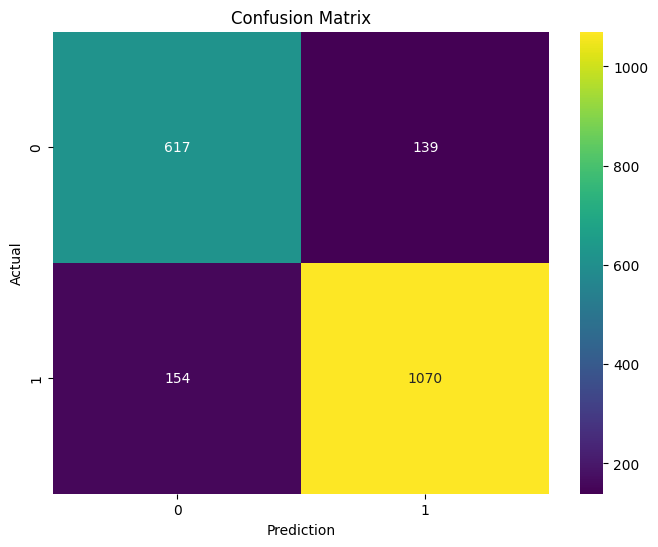

In [21]:
plt.figure(figsize = (8,6))
sns.heatmap(matrix, annot = True, fmt = '.0f', cmap = 'viridis')
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [22]:
report = metrics.classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       756
           1       0.89      0.87      0.88      1224

    accuracy                           0.85      1980
   macro avg       0.84      0.85      0.84      1980
weighted avg       0.85      0.85      0.85      1980



## SMOTE data

In [23]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [24]:
grid_search_resampled = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid_search_resampled.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constr...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [25]:
y_pred_resample = grid_search_resampled.predict(X_test_resampled)
matrix = metrics.confusion_matrix(y_test_resampled, y_pred_resample)

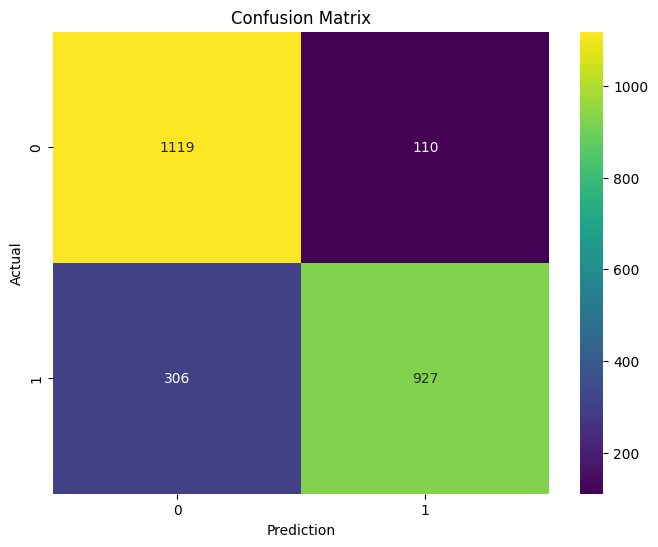

In [26]:
plt.figure(figsize = (8,6))
sns.heatmap(matrix, annot = True, fmt = '.0f', cmap = 'viridis')
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [28]:
report = metrics.classification_report(y_test_resampled, y_pred_resample)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.91      0.84      1229
           1       0.89      0.75      0.82      1233

    accuracy                           0.83      2462
   macro avg       0.84      0.83      0.83      2462
weighted avg       0.84      0.83      0.83      2462



# Save model

In [33]:
import joblib

In [34]:
joblib.dump(grid_search_resampled, "grid_search_model.pkl")

['grid_search_model.pkl']